# Brain Tumor Detection with KNN and Custom Preprocessing
Ova bilježnica prikazuje detekciju tumora mozga na MRI slikama korištenjem KNN algoritma i vlastitog skupa podataka BinaryBrainTumorDataset.

## 1. Uvod i ciljevi
Cilj je izgraditi model koji klasificira MRI slike na tumorske i netumorske koristeći KNN algoritam. Skup podataka: `BinaryBrainTumorDataset` s dvije klase: "yes" (tumor) i "no" (bez tumora).

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imutils
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from skimage.feature import hog, graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler

## 2. Učitavanje i raspodjela podataka
Učitavamo slike iz direktorija, raspodjeljujemo ih na train, validation i test skupove.

In [3]:
IMG_SIZE = (96, 96)  # Manje slike zbog KNN-a
DATASET_DIR = "../data/BinaryBrainTumorDataset/Training"
TEST_DIR = "../data/BinaryBrainTumorDataset/Testing"

def load_images_from_folder(folder, label, img_size):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    return images, labels

X = []
y = []
for class_name in ["yes", "no"]:
    imgs, labels = load_images_from_folder(os.path.join(DATASET_DIR, class_name), 1 if class_name == "yes" else 0, IMG_SIZE)
    X.extend(imgs)
    y.extend(labels)

X = np.array(X)
y = np.array(y)

# Split into train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

## 3. Vizualizacija podataka
Prikaz nekoliko slika iz obje klase.

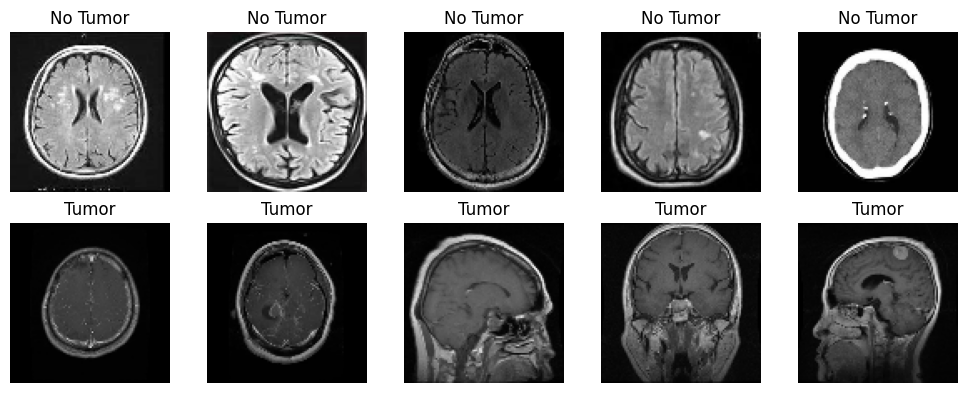

In [4]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[y_train == 0][i])
    plt.title("No Tumor")
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    plt.imshow(X_train[y_train == 1][i])
    plt.title("Tumor")
    plt.axis("off")
plt.tight_layout()
plt.show()

## 4. Predobrada: automatsko croppanje mozga
Koristi se kontura za izrezivanje regije mozga iz slike.

In [5]:
def crop_brain(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts) == 0:
        return img
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    cropped = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    cropped = cv2.resize(cropped, IMG_SIZE)
    return cropped

X_train_crop = np.array([crop_brain(img) for img in X_train])
X_val_crop = np.array([crop_brain(img) for img in X_val])

## 5. Priprema podataka za KNN
Slike se pretvaraju u vektore značajki (flatten) i skaliraju.

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)

## 6. Model: KNN
Treniranje KNN klasifikatora (k=5).

In [7]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


## 7. Evaluacija modela
Prikaz točnosti, ROC krivulje i matrice zabune.

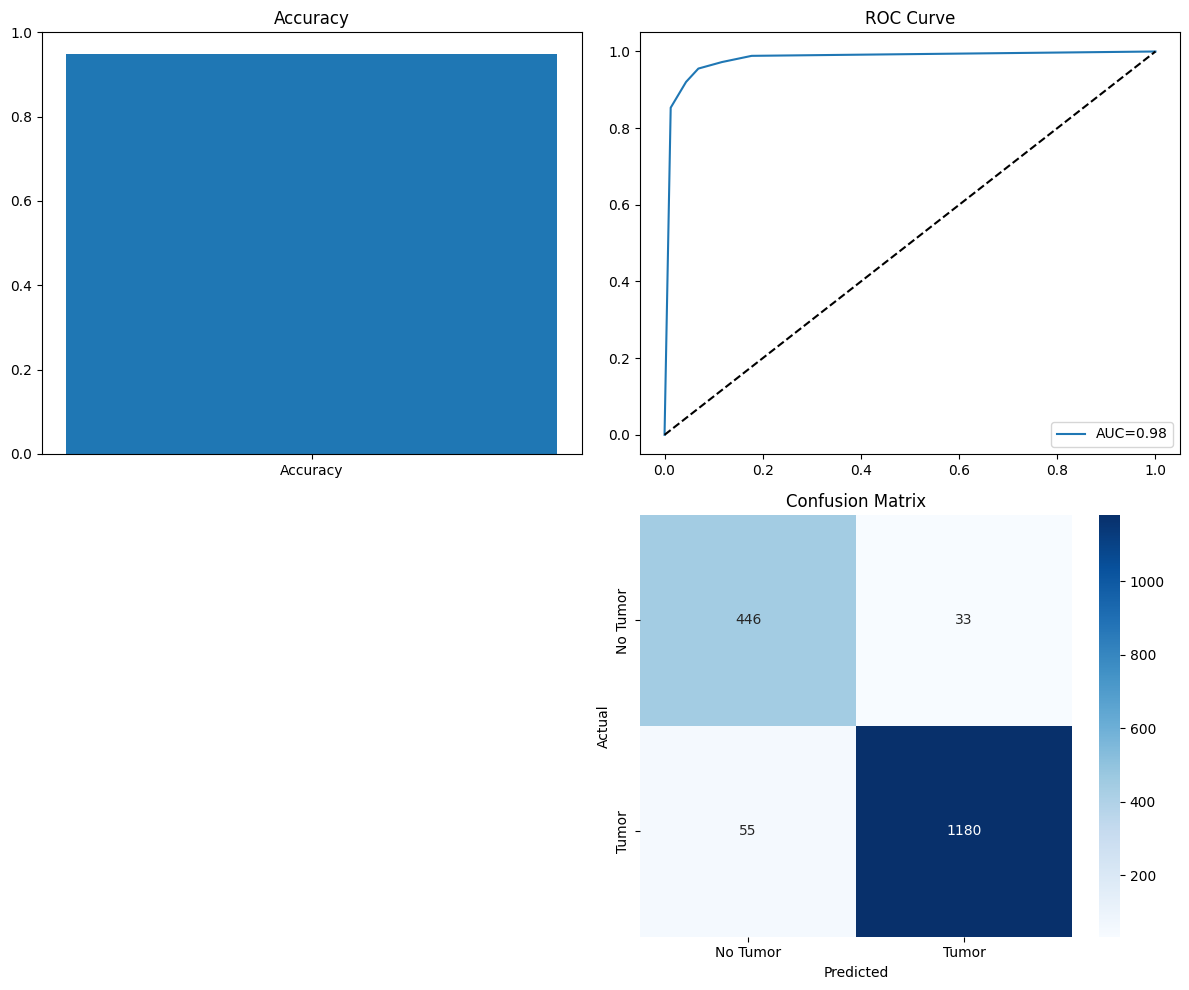

Validation Accuracy: 0.9487
              precision    recall  f1-score   support

    No Tumor       0.89      0.93      0.91       479
       Tumor       0.97      0.96      0.96      1235

    accuracy                           0.95      1714
   macro avg       0.93      0.94      0.94      1714
weighted avg       0.95      0.95      0.95      1714

Tocnost (accuracy): 0.9487
Preciznost (precision): 0.9497
F1 rezultat: 0.9490
AUC-ROC: 0.9802


In [8]:
val_preds = knn.predict(X_val_scaled)
val_probs = knn.predict_proba(X_val_scaled)[:, 1]
accuracy = accuracy_score(y_val, val_preds)
cm = confusion_matrix(y_val, val_preds)
fpr, tpr, _ = roc_curve(y_val, val_probs)
roc_auc = auc(fpr, tpr)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# Accuracy in first column (top)
axes[0, 0].bar(["Accuracy"], [accuracy])
axes[0, 0].set_ylim(0, 1)
axes[0, 0].set_title("Accuracy")
axes[0, 0].set_ylabel("")
axes[0, 0].set_xlabel("")
axes[1, 0].axis('off')  # Empty cell below accuracy
# ROC Curve in second column (top)
axes[0, 1].plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
axes[0, 1].plot([0, 1], [0, 1], "k--")
axes[0, 1].set_title("ROC Curve")
axes[0, 1].legend()
# Confusion Matrix in second column (bottom)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"], ax=axes[1, 1])
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("Actual")
axes[1, 1].set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

print(f"Validation Accuracy: {accuracy:.4f}")
print(classification_report(y_val, val_preds, target_names=["No Tumor", "Tumor"]))

print(f"Tocnost (accuracy): {accuracy:.4f}")
report_dict = classification_report(y_val, val_preds, target_names=["no", "yes"], output_dict=True)
print(f"Preciznost (precision): {report_dict['weighted avg']['precision']:.4f}")
print(f"F1 rezultat: {report_dict['weighted avg']['f1-score']:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

## 8. Zaključak
KNN model s osnovnom predobradom daje dobre rezultate na zadatku detekcije tumora mozga. Daljnja poboljšanja mogu uključivati optimizaciju broja susjeda i naprednije ekstrakcije značajki.

## 5a. Ekstrakcija HOG i GLCM značajki
U ovoj sekciji izdvajamo HOG i GLCM značajke iz slika te ih koristimo kao ulaz u KNN model.

In [ ]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(features)
    return np.array(hog_features)

def extract_glcm_features(images):
    glcm_features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        glcm_features.append([contrast, homogeneity, energy, correlation])
    return np.array(glcm_features)

# Ekstrakcija značajki za train i val skup
X_train_hog = extract_hog_features(X_train)
X_val_hog = extract_hog_features(X_val)
X_train_glcm = extract_glcm_features(X_train)
X_val_glcm = extract_glcm_features(X_val)

# Kombiniraj HOG i GLCM značajke
X_train_feat = np.concatenate([X_train_hog, X_train_glcm], axis=1)
X_val_feat = np.concatenate([X_val_hog, X_val_glcm], axis=1)

# Skaliraj značajke
scaler_feat = StandardScaler()
X_train_feat_scaled = scaler_feat.fit_transform(X_train_feat)
X_val_feat_scaled = scaler_feat.transform(X_val_feat)

## 6a. KNN na HOG+GLCM značajkama
Treniranje i evaluacija KNN modela na izdvojenim značajkama.

In [ ]:
knn_feat = KNeighborsClassifier(n_neighbors=5)
knn_feat.fit(X_train_feat_scaled, y_train)

val_preds_feat = knn_feat.predict(X_val_feat_scaled)
val_probs_feat = knn_feat.predict_proba(X_val_feat_scaled)[:, 1]
accuracy_feat = accuracy_score(y_val, val_preds_feat)
cm_feat = confusion_matrix(y_val, val_preds_feat)
fpr_feat, tpr_feat, _ = roc_curve(y_val, val_probs_feat)
roc_auc_feat = auc(fpr_feat, tpr_feat)

print(f"Validation Accuracy (HOG+GLCM): {accuracy_feat:.4f}")
print(classification_report(y_val, val_preds_feat, target_names=["No Tumor", "Tumor"]))
print(f"AUC-ROC: {roc_auc_feat:.4f}")